#4주차 과제 설명
<p>이번 과제의 목표는 세션 시간에 배운 Generation model 중 GAN을 실습해보면서
 1) discriminator와 generator를 어떻게 교대로 학습시켜야 하는지 2) 실제로 어떤 이미지가 생성되는지 3) GAN을 발전시킨 LSGAN과 DCGAN은 어떻게 구현되는지에 대해 여러분들이 직접 느끼는 것입니다.</p>

<p>GAN을 직접 scratch부터 구현하는 것은 어려운 일이기에, 글로만 들었던 개념을 좀 더 상세히 코드로 이해하는데 중점을 두었습니다. 😂</p>

<p> 과제는 훌륭한 교보재인 CS231 공식 assignment3을 다수 참고하였습니다 🙇🏻‍♂️</p>

해당 과제는 런타임 연결시 'GPU' 사용을 강력히 권장드립니다!!(CPU 쓰면 학습시킬 때 많이 느립니다..!)

# Generative Adversarial Networks (GANs)


In [3]:
# Setup cell. run!
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return


gan-checks.npz는 코드과제.ipynb와 함께 올려드린 파일로 colab 기준 좌측 파일 버튼 누르셔서 현재 위치에 업로드하신 후에 아래 코드를 실행하시면 됩니다!

과제에 틀린 답안을 작성한 후 계속 코드를 실행하면서 시간 낭비하지 않도록 답안이 맞을 때까지 체크해주는 파일입니다 ㅎㅎ

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 현재위치에 파일 업로드 후 실행. 문제 발생 시 DM 주세요!
#answers = dict(np.load('gan-checks.npz'))
answers = dict(np.load('/content/drive/MyDrive/2024_KUBIG-CV/gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# Help Functions 1
기본적인 전처리 함수들입니다

In [6]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

## Dataset
학습 데이터는 MNIST 데이터를 사용합니다 :)

100%|██████████| 9912422/9912422 [00:00<00:00, 107984092.25it/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106633533.30it/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32316192.45it/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21697640.97it/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw



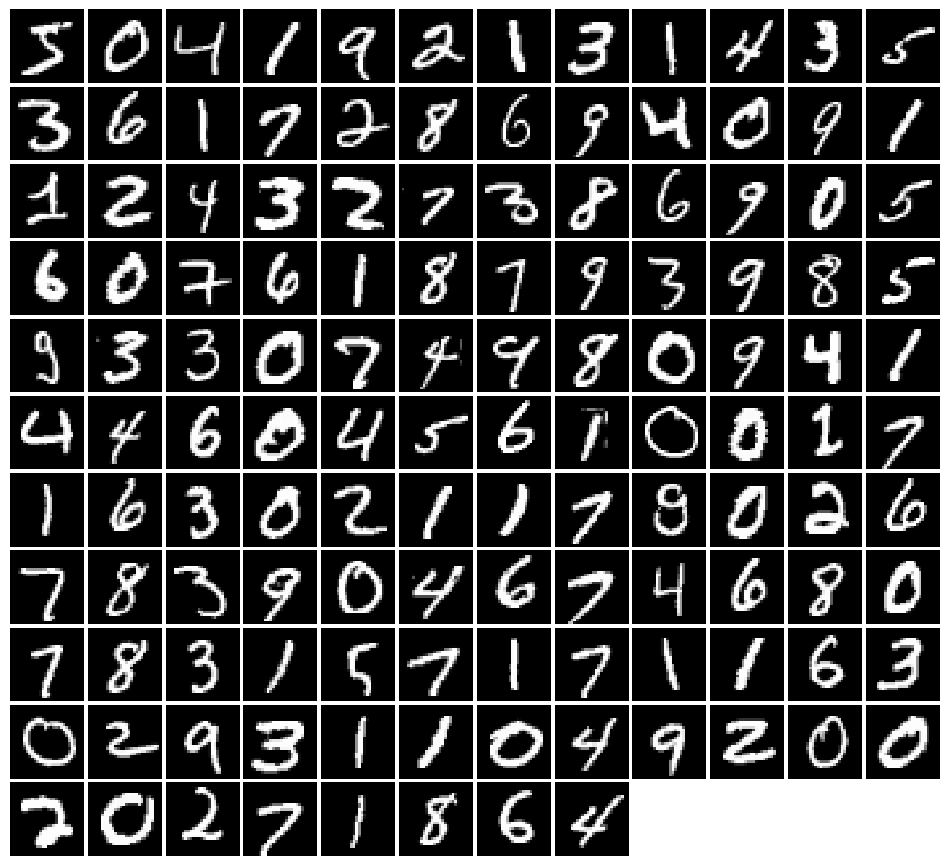

In [7]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128


# 바로 실행하셔도 되고, MNIST data를 받을 경로설정을 환경에 맞게 설정해주셔도 됩니다.
mnist_train = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

imgs = next(loader_train.__iter__())[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise : Input of Generation Network


# H.W 1

첫번째 과제는 가짜 이미지를 생성하는 Generator에 입력할 '노이즈'를 샘플링하는 함수를 작성하는 문제입니다. Hint에 주어진 함수를 사용하고 shape와 range를 고려하여 노이즈 샘플링 함수를 완성해주세요!

In [8]:
def sample_noise(batch_size, dim, seed=None):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.

    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    if seed is not None:
        torch.manual_seed(seed)

    # ************* START ******************
    # TODO : random noise를 만드는 식을 짜주세요
    # Hint 1: -1부터 1사이의 uniform noise를 만들어주세요. shape은 [batch_size, dim] 입니다.
    # Hint 2: torch.rand를 사용하세요
    uniform_noise=torch.rand(batch_size, dim)*2-1 #0부터 1까지의 난수 -> -1~1로 만들기 위해서는 *2 -1

    return uniform_noise

    # ************* END ******************

In [9]:
# sample_noise 함수를 잘 만들었는지 테스트하는 함수입니다. 에러 발생 시 Hint를 다시 확인해주세요!

def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')

test_sample_noise()

All tests passed!


## Flatten & Unflatten & Weight initalization

1차원의 벡터를 만들어주는 flatten 함수(Generator)와 그 반대인 unflatten(Discriminator), 그리고  weight initializer로 자주 쓰이는 Xavier initalization입니다. 과제 시 사용되는 함수이니 기억해주세요!

In [10]:
# run!

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data)

# H.W 2 : Discriminator

Discriminator는 아래와 같은 구조입니다.


 * nn.Flatten()
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1


*   마지막 output shape은 [batch_size, 1] 형태를 갖습니다






빈칸에 들어가야 할 코드를 완성해주세요! 코드를 작성하면서 vanila GAN의 네트워크가 어떻게 구성되어 있는지 이해하시면 됩니다.

In [13]:
def discriminator(seed=None):
    """
    Build and return a PyTorch model implementing the architecture above.
    """

    if seed is not None:
        torch.manual_seed(seed)

    model = None

    # ************* START ******************

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,256),
        nn.LeakyReLU(0.01),
        nn.Linear(256,256),
        nn.LeakyReLU(0.01),
        nn.Linear(256,1),
        #1인 이유: 가짜 or 진짜 판별, output shape이 [batch_size, 1] 형태 << batch size는 몇 개 이미지 처리했는지 자동으로 포함됨, MNIST dataset에서 batch_size = 128
        #1개 이미지 처리할 때마다 FC layer의 output size가 1-> 1개의 출력값을 냄
    )

    # *************** END *******************

    return model


In [14]:
# 완성한 Discriminator의 파라미터 수가 일치하는지 확인
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')

test_discriminator()

Correct number of parameters in discriminator.


# Generator

Generator는 아래와 같은 구조입니다



 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with output size 1024
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (to clip the image to be in the range of [-1,1])


Discriminator와 마찬가지로 빈칸을 적절하게 채워주시면 됩니다!

In [22]:
def generator(noise_dim=NOISE_DIM, seed=None):
    """
    Build and return a PyTorch model implementing the architecture above.
    """

    if seed is not None:
        torch.manual_seed(seed)

    model = None

    model = nn.Sequential(
        nn.Linear(noise_dim,1024), #MNIST dataset에서 NOISE_DIM = 96
        nn.ReLU(),
        nn.Linear(1024,1024),
        nn.ReLU(),
        nn.Linear(1024,784),
        nn.Tanh() #output: -1~1 사이의 값의 784차원 벡터
    )

    return model

In [23]:
# 완성한 generator의 파라미터 수가 일치하는지 확인
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# H.W 3 : GAN Loss


##   Generator Loss
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$ <br>

## Discriminator Loss
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$ <Br>

이 Loss들을 minimizing하기 위해 원래 Loss식에 -를 붙였습니다.

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$ <Br>

*   해당 식을 나이브하게 적용하면 unstable하기 때문에 아래의 bce 함수에 stable한 implementation을 제공하였습니다.

* $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$ 의 expectation을 계산하는 방식이 아닌, minibatch 원소에 대해 averaging을 취하는 방식을 사용합니다.



Test your generator and discriminator loss. You should see errors < 1e-7.

In [44]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.

    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    # ************* START ******************
    # TODO: Fake image에 대한 loss와 Real image에 대한 loss를 각각 계산하고 평균화하세요
    # Hint: 위에서 정의한 bce_loss()를 사용하여 binary cross-entropy방식으로 각 element들에 대한 loss를 계산합니다
    # Hint: 이때 bce_loss()의 input은 logits_xxxx이며 target은 torch.zeros_like와 torch.ones_like를 사용해서 정의해주세요!

    loss_fake = bce_loss(logits_fake,torch.zeros_like(logits_fake))
    loss_real = bce_loss(logits_real,torch.ones_like(logits_real))
    loss = (loss_real + loss_fake) / 2

    # ************* END ******************
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    # ************* START ******************
    # TODO: Fake image에 대한 loss를 계산하세요
    # Hint: torch.zeros_like와 torch.ones_like 중 하나를 선택해서 정의해주세요!

    loss = bce_loss(logits_fake,torch.ones_like(logits_fake))

    # ************* END ******************
    return loss


In [45]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_true']
)

Maximum error in d_loss: 0.333333


In [46]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(
    answers['logits_fake'],
    answers['g_loss_true']
)

Maximum error in g_loss: 4.4518e-09


# Optimizing our Loss

# Training a GAN!



# H.W 4

In [54]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.

    Input:
    - model: A PyTorch model that we want to optimize.

    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = None
    # ************* START ******************
    #TODO : Adam optimizer를 정의해주세요. learning rate 조절 및 scheduler도 적용해보세요.

    optimizer = optim.Adam(model.parameters(),lr=1e-3, betas=(0.5,0.999))

    # ************* END ******************
    return optimizer


def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250,
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.

    """
    images = []
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue


            # ************* START ******************
            #TODO 1. Discriminator 학습과정
            # Real images에 대해 logits_real을 정의하고 fake_images에 대해 logits_fake를 정의해야 합니다.
            # D_solver는 optimizer입니다.
            # 1. real_images : real_images를 위 반복문에서 출력되는 image data=x로 정의해주세요. 이때 .type(dtype)로 type을 맞춰주셔야 합니다.
            # 2. logits_real : real_data의 range를 [0,1]에서 [-1,1]로 변경한 후 pytorch Discriminator model인 D()에 입력해주세요.
            # 마찬가지로 .type(dtype)로 type을 맞춰주셔야 합니다.


            # 실제 이미지에 대한 loss 계산
            D_solver.zero_grad()
            real_images = x.type(dtype) #0~1 range
            logits_real = D(real_images*2-1) #-1~1로 변경 -> *2 -1


            # 가짜  이미지를 생성한 후 loss 계산
            # 3. fake_images : 생성한 noise를 pytorch generator model인 G()에 입력해주세요.
            # 이때 Discriminator의 학습과정이므로 Generator는 고정되어야 하며, gradient 계산과정에 사용되지 않도록 설정해주어야 합니다.(중요)
            # pytorch method를 이용해 tensor의 gradient가 전파되지 않도록 만들어주세요.(stop_gradient)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype) #def sample_noise(batch_size, dim, seed=None):
            fake_images = G(g_fake_seed).detach() #stop_gradient라는 함수는 존재하지 않으며, detach라는 메서드가 有
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            #TODO 2. Generator 학습과정
            #fake_image에 대해서만 loss를 계산합니다.
            #Discriminator와 비슷한 방식으로 가중치를 업데이트 하는 것까지 코드를 작성해주세요

            # 1. G_solver의 gradient를 초기화합니다.
            # 2. g_fake_seed : fake image를 만들어주기 위한 g_fake_seed를 정의합니다.
            # 3. fake_images : 생성한 g_fake_seed를 pytorch generator model에 입력해주세요.
            # Generator 학습과정이기 때문에 앞서 정의한 fake_images와 달리 stop_gradient를 고려하지 않습니다.
            # 4. gen_logits_fake : fake_images를 MMNIST size인 1,28,28에 맞게 변경한 뒤 discriminator model에 입력해주세요.
            # 5. g_error : 앞에서 직접 정의한 generator의 loss를 계산해주는 함수에 입력합니다.
            # 6. 정의한 g_error의 gradient를 계산합니다.
            # 7. optimizer의 파라미터를 업데이트합니다.

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype) # 2. fake image
            fake_images = G(g_fake_seed)
            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            g_error = generator_loss(gen_logits_fake)
            g_error.backward() # 6. gradient 계산 method
            G_solver.step() #7. optimizer의 파라미터를 업데이트하는 method


            # ************* END ******************


            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                images.append(imgs_numpy[0:16])

            iter_count += 1

    return images

In [55]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train
)

Iter: 0, D: 0.6736, G:0.7083
Iter: 250, D: 0.5613, G:0.9098
Iter: 500, D: 0.5136, G:1.12
Iter: 750, D: 0.6051, G:1.638
Iter: 1000, D: 0.6564, G:1.259
Iter: 1250, D: 0.5932, G:0.9552
Iter: 1500, D: 0.7072, G:1.655
Iter: 1750, D: 0.6396, G:1.013
Iter: 2000, D: 0.6255, G:0.9106
Iter: 2250, D: 0.6736, G:0.9853
Iter: 2500, D: 0.6603, G:0.8936
Iter: 2750, D: 0.6203, G:0.8898
Iter: 3000, D: 0.6551, G:0.784
Iter: 3250, D: 0.6678, G:1.039
Iter: 3500, D: 0.6941, G:0.8025
Iter: 3750, D: 0.6633, G:0.8446


Run the cell below to show the generated images.

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

Vanilla GAN output image

In [ ]:
# This output is your answer.
print("Vanilla GAN final image:")
show_images(images[-1])
plt.show()

# Least Squares GAN
LSGAN은 original GAN의 unstable loss function을 개선한 GAN입니다.
모델 구조는 바뀌지 않았지만 loss function이 이전과 다릅니다. <br>
[Least Squares GAN](https://arxiv.org/abs/1611.04076)



## Generation loss

$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$ <br>

## Discriminator loss
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$ <br>


*   앞의 Vanilla GAN loss와 마찬가지로 expectation을 계산하는 방식이 아닌, minibatch 원소에 대해 averaging을 취하는 방식을 사용합니다.

*    $D(x)$ and $D(G(z))$ 는 discriminator (`scores_real` and `scores_fake`).에서 나온 direct output을 사용합니다.



# H.W 5

In [56]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.

    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    ##############################################################################
    # TODO: LSGAN의 Discriminator loss를 구현해보세요 (Markdown에 적혀있는 수식을 참고하세요)
    # Hints : scores_real은 D(x)의 output을 의미합니다. #실제데이터 x에 대해 판별자가 출력
    # Hints : scores_fake는 D(G(z))의 output을 의미합니다. #생성 데이터에 대해 판별자가 출력
    ##############################################################################
    # ************* START ******************

    loss = (1/2) * ((scores_real - 1) ** 2).mean() + (1/2) * ((scores_fake) ** 2).mean()

    # ************* END ******************
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.

    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    ##############################################################################
    # TODO: LSGAN의 Generator loss를 구현해보세요 (Markdown에 적혀있는 수식을 참고하세요)
    # Hints : scores_fake는 D(G(z))의 output을 의미합니다.                                                                                 #
    ##############################################################################
    # ************* START ******************

    loss = (1/2) * ((scores_fake - 1) ** 2).mean()

    # ************* END ******************
    return loss

In [57]:
# 두 loss가 제대로 정의되었는지 확인
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_lsgan_true'],
    answers['g_loss_lsgan_true']
)

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


Run the following cell to train your model!

In [58]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(
    D_LS,
    G_LS,
    D_LS_solver,
    G_LS_solver,
    ls_discriminator_loss,
    ls_generator_loss,
    loader_train
)

Iter: 0, D: 0.5388, G:0.4644
Iter: 250, D: 0.09306, G:0.2236
Iter: 500, D: 0.1114, G:0.4187
Iter: 750, D: 0.1806, G:1.087
Iter: 1000, D: 0.1765, G:0.2635
Iter: 1250, D: 0.2031, G:0.1739
Iter: 1500, D: 0.2396, G:0.1547
Iter: 1750, D: 0.2071, G:0.1653
Iter: 2000, D: 0.2055, G:0.1981
Iter: 2250, D: 0.2188, G:0.189
Iter: 2500, D: 0.2371, G:0.1713
Iter: 2750, D: 0.2224, G:0.1834
Iter: 3000, D: 0.223, G:0.1771
Iter: 3250, D: 0.2221, G:0.2814
Iter: 3500, D: 0.2348, G:0.1708
Iter: 3750, D: 0.2522, G:0.1472


Run the cell below to show generated images.

Iter: 0


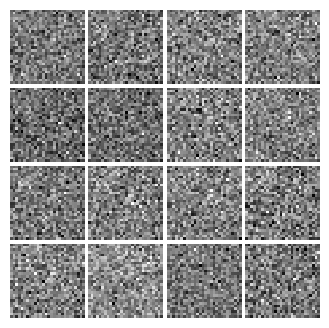


Iter: 250


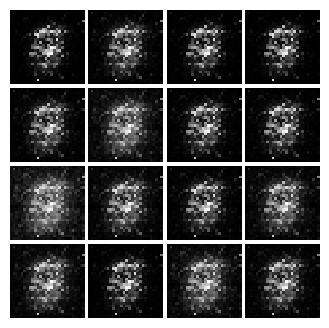


Iter: 500


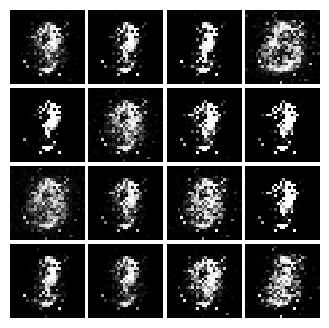


Iter: 750


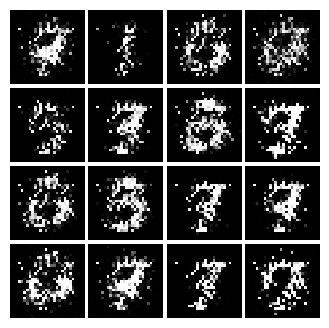


Iter: 1000


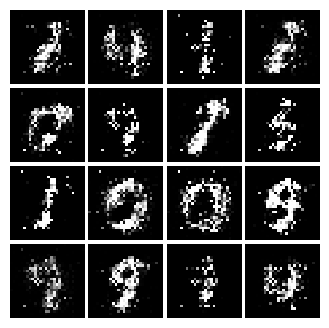


Iter: 1250


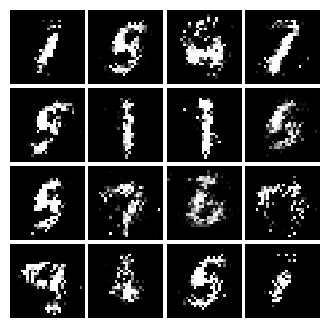


Iter: 1500


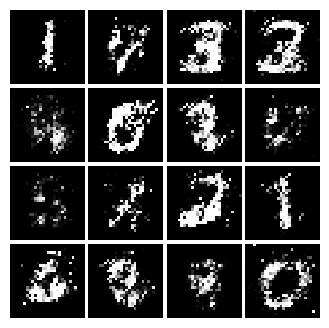


Iter: 1750


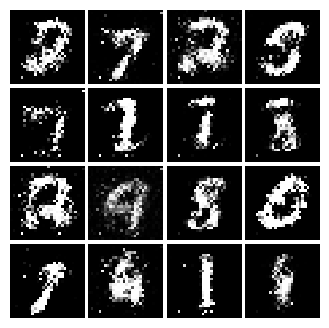


Iter: 2000


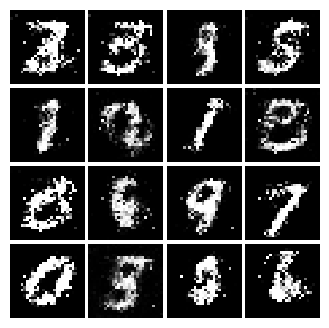


Iter: 2250


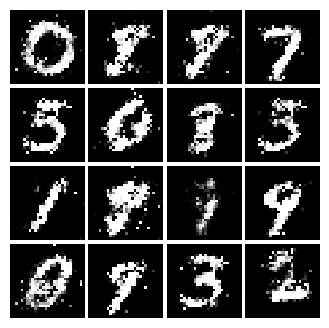


Iter: 2500


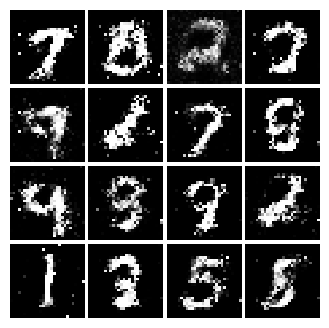


Iter: 2750


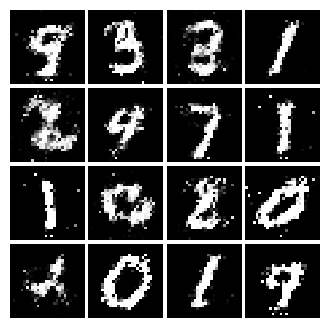


Iter: 3000


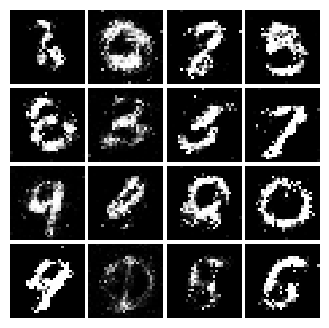


Iter: 3250


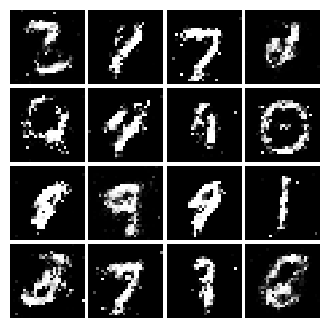


Iter: 3500


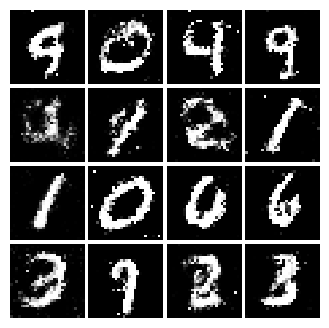


Iter: 3750


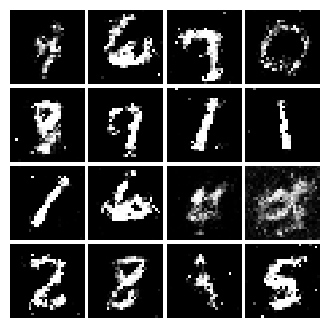

In [59]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

LSGAN output image

LSGAN final image:


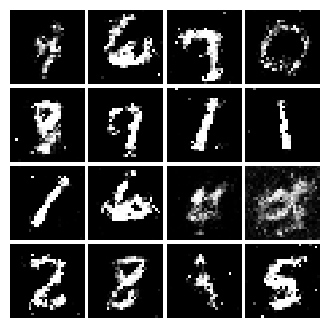

In [60]:
# This output is your answer.
print("LSGAN final image:")
show_images(images[-1])
plt.show()

# Deeply Convolutional GANs
Discriminator와 Generator 네트워크를 정의할 때 FC-layer만 사용한 vanila GAN와 달리 Convolutional layer를 도입한 DCGAN을 실습합니다 :) <br>
[DCGAN](https://arxiv.org/abs/1511.06434)



# H.W 6

#### Discriminator

아래의 Discriminator architecture를 코드로 작성해주세요!


* Reshape into MNIST image tensor (Use Unflatten(N=, C=, H=, W=)!)
* Conv2D: out_channels=32 , 5x5, Stride 1, Padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: out_channels=64, 5x5, Stride 1, Padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten()
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [100]:
def build_dc_classifier(batch_size):
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """

    ##############################################################################
    # TODO: Discriminator를 build하세요                                                                                           #
    # HINT: nn.Sequential를 사용하면 편합니다
    #class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    #def __init__(self, N=-1, C=128, H=7, W=7):
    ##############################################################################
    # ************* START ******************

    model = nn.Sequential(
        #nn.Unflatten(1,1,28,28),
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(4*4*64, 4*4*64),
        nn.LeakyReLU(0.01),
        nn.Linear(4*4*64, 1),
    )

    return model
    # ************* END ******************
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

In [101]:
data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [102]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


#### Generator
DCGAN에서 사용할 generator의 구조는  InfoGAN paper의 구조와 동일합니다 <br>
[InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). <br>
수업 시간에 말한 upsampling 기법도 transpose convolution으로 수행하니 아래의 architecture를 코드로 작성해주세요!

* Fully connected with input size noise_dim and output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128 (Use Unflatten(N=, C=, H=, W=)!)
* Conv2D^T (Transpose): out_channels=64 ,4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): out_channels=1, 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector (use Flatten())



#H.W 7

In [103]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """

    ##############################################################################
    # TODO: Generator를 build하세요                                                                                           #
    # HINT: nn.Sequential를 사용하면 편합니다
    # HINT: BatchNorm 정의 시 1d와 2d를 구분하셔야 합니다.
    ##############################################################################
    # ************* START ******************

    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*128),
        nn.Unflatten(1, (128, 7, 7)),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        nn.Flatten()
    )

    return model
    # ************* END ******************

In [104]:
test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [105]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


In [106]:
D_DC = build_dc_classifier(batch_size).type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    discriminator_loss,
    generator_loss,
    loader_train,
    num_epochs=5
)

Iter: 0, D: 0.729, G:0.6825
Iter: 250, D: 0.6997, G:1.151
Iter: 500, D: 0.574, G:1.099
Iter: 750, D: 0.5735, G:1.013
Iter: 1000, D: 0.6274, G:0.8308
Iter: 1250, D: 0.6141, G:0.9253
Iter: 1500, D: 0.5481, G:0.9731
Iter: 1750, D: 0.574, G:0.9327


Run the cell below to show generated images.

Iter: 0


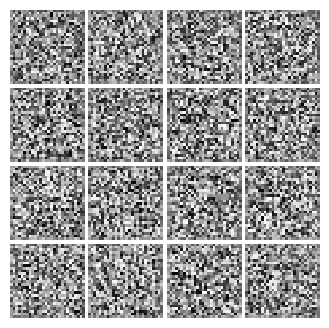


Iter: 250


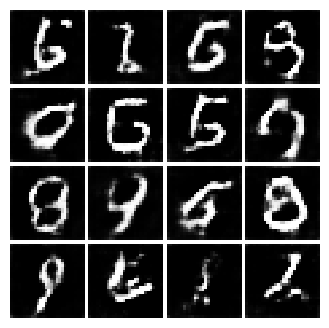


Iter: 500


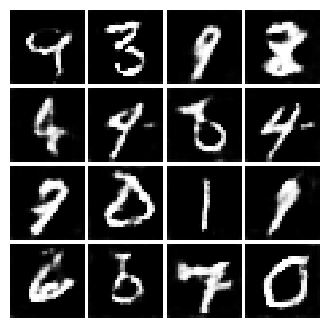


Iter: 750


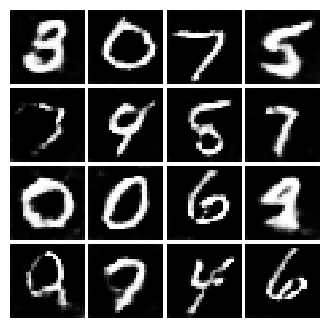


Iter: 1000


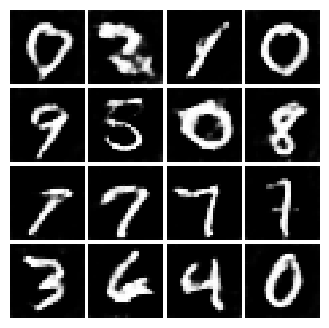


Iter: 1250


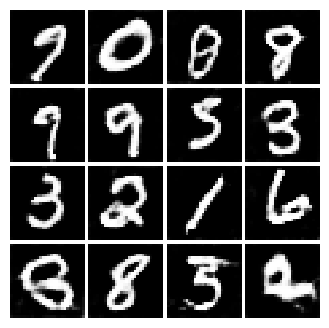


Iter: 1500


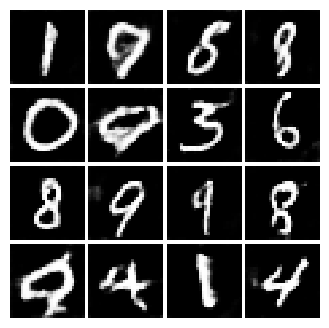


Iter: 1750


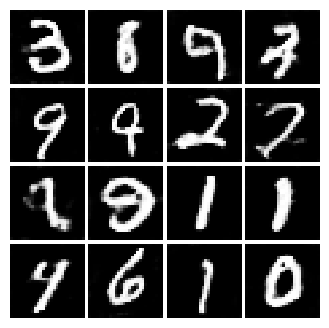

In [107]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

DCGAN output image

DCGAN final image:


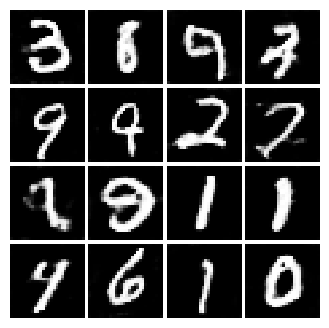

In [108]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()

4주 동안 모두 고생 많으셨습니다 :) 많이 부족한 세션과 과제임에도 불구하고 잘 따라와주셔서 정말 감사드립니다.

추운 날씨에 건강 조심하시고 남은 프로젝트와 스터디도 끝까지 화이팅 하시기를 응원하겠습니다 ㅎㅎ 과제 또는 이외에 궁금한 사항이 있다면 언제든지 17기 임청수에게 DM 보내주세요! 🙇🏻‍♂️